In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy
import numpy as np  

In [2]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 50

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle=True,
    image_size= (IMAGE_SIZE, IMAGE_SIZE),
    batch_size= BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [4]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [5]:
len(dataset)

68

In [6]:
68*32

2176

In [7]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape) 
    print(label_batch.numpy())

(32, 256, 256, 3)
[0 1 1 0 1 1 1 0 1 2 1 1 0 0 0 1 2 0 0 0 1 1 0 1 2 1 2 0 1 0 0 1]


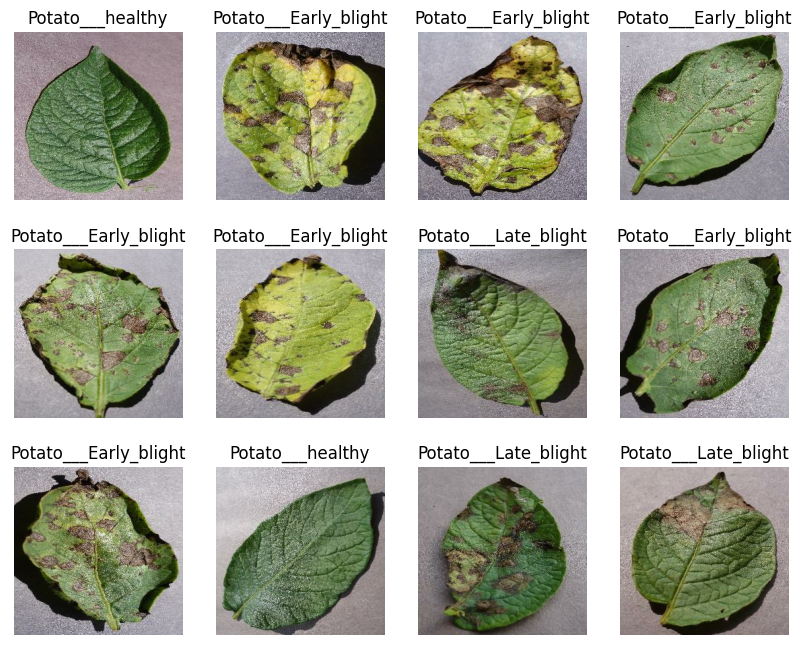

In [8]:
plt.figure(figsize=(10, 8))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [9]:
len(dataset)

68

In [10]:
# 80% ==> training
# 20% ==> 10% validation, 10% testing

In [11]:
(80/100)*68

54.400000000000006

In [12]:
train_size = 0.8
len(dataset)*train_size

54.400000000000006

In [13]:
train_ds = dataset.take(54)
len(train_ds)

54

In [14]:
test_ds = dataset.skip(54)
len(test_ds)

14

In [15]:
val_size = 0.1
len(dataset)*val_size

6.800000000000001

In [16]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [17]:
test_ds = test_ds.skip(6)
len(test_ds)

8

### train test split

In [18]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
        
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)
    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [19]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [20]:
print(f"train size: {len(train_ds)}")
print(f"validation size: {len(val_ds)}")
print(f"test size: {len(test_ds)}")

train size: 54
validation size: 6
test size: 8


### Cache, Shuffle, and Prefetch the Dataset

In [21]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

### Building the Model
#### Creating a Layer for Resizing and Normalization
##### values set to --> 0 to 1

In [22]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1./255)
])

### Data Augmentation
##### Data Augmentation is needed when we have less data, this boosts the accuracy of our model by augmenting the data.

In [23]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [24]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [25]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

### Compiling model

In [26]:
import tensorflow as tf

model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [27]:
history = model.fit(
    train_ds,
    batch_size= BATCH_SIZE,
    validation_data = val_ds,
    verbose = 1,
    epochs = 50
)

Epoch 1/50
54/54 [==============================] - 18s 155ms/step - loss: 0.9112 - accuracy: 0.5220 - val_loss: 0.8790 - val_accuracy: 0.6198
Epoch 2/50
54/54 [==============================] - 5s 99ms/step - loss: 0.6528 - accuracy: 0.7095 - val_loss: 0.3613 - val_accuracy: 0.8281
Epoch 3/50
54/54 [==============================] - 5s 99ms/step - loss: 0.4311 - accuracy: 0.8119 - val_loss: 0.3284 - val_accuracy: 0.9062
Epoch 4/50
54/54 [==============================] - 5s 96ms/step - loss: 0.3263 - accuracy: 0.8582 - val_loss: 0.3641 - val_accuracy: 0.8438
Epoch 5/50
54/54 [==============================] - 5s 96ms/step - loss: 0.2094 - accuracy: 0.9172 - val_loss: 0.1449 - val_accuracy: 0.9479
Epoch 6/50
54/54 [==============================] - 5s 97ms/step - loss: 0.1998 - accuracy: 0.9190 - val_loss: 0.1152 - val_accuracy: 0.9583
Epoch 7/50
54/54 [==============================] - 5s 97ms/step - loss: 0.2256 - accuracy: 0.9126 - val_loss: 0.1292 - val_accuracy: 0.9635
Epoch 8/50


In [31]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 0s 30ms/step - loss: 0.0612 - accuracy: 0.9883


In [29]:
history

In [30]:
print(history.params)

{'verbose': 1, 'epochs': 50, 'steps': 54}


In [32]:
scores

[0.06122756376862526, 0.98828125]

In [33]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [35]:
type(history.history['loss'])

list

In [36]:
len(history.history['loss'])

50

In [37]:
history.history['loss'][:5]

[0.9111526012420654,
 0.6528357267379761,
 0.43106403946876526,
 0.3262889087200165,
 0.20944641530513763]

In [38]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

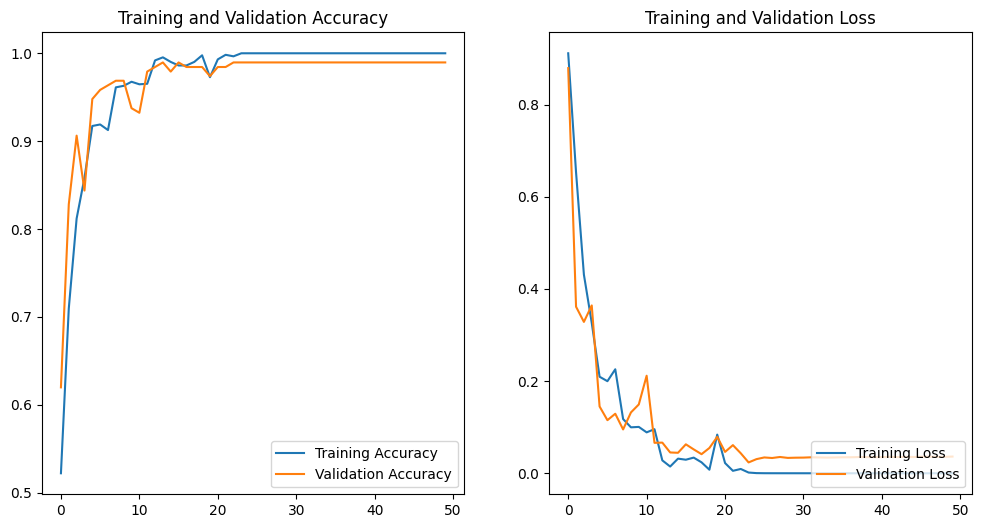

In [50]:
plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)

plt.plot(range(EPOCHS), acc, label = 'Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label = 'Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label = 'Training Loss')
plt.plot(range(EPOCHS), val_loss, label = 'Validation Loss')
plt.legend(loc='lower right')
plt.title('Training and Validation Loss')
plt.show()

### Run prediction on sample image

first image to predict
actual label:  Potato___Early_blight
1/1 [==============================] - 0s 26ms/step
predicted label:  Potato___Early_blight


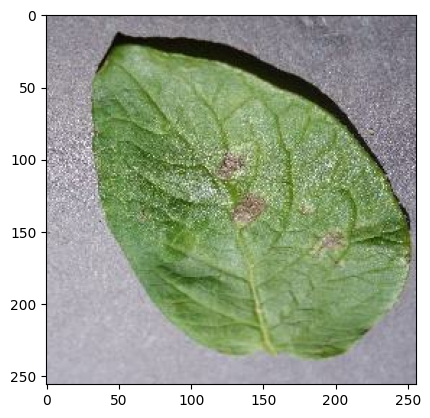

In [71]:
import numpy as np
for image_batch, label_batch in test_ds.take(1):
    
    first_image = image_batch[0].numpy().astype('uint8')
    first_label = label_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label: ", class_names[first_label])
    
    bact_prediction = model.predict(image_batch)
    print("predicted label: ", class_names[np.argmax(bact_prediction[0])])

## Pediction function

In [78]:
import numpy as np
import tensorflow as tf

def predict(model, image):
    # If `image` is already a NumPy array, don't convert it to NumPy again
    img_array = tf.keras.preprocessing.image.img_to_array(image)
    img_array = tf.expand_dims(img_array, 0)  # Expand dimensions to create a batch of one image
    
    predictions = model.predict(img_array)
    
    predicted_class = class_names[np.argmax(predictions[0])]  # Get the predicted class
    confidence = round(100 * (np.max(predictions[0])), 2)  # Get the confidence level
    
    return predicted_class, confidence

1/1 [==============================] - 0s 31ms/step


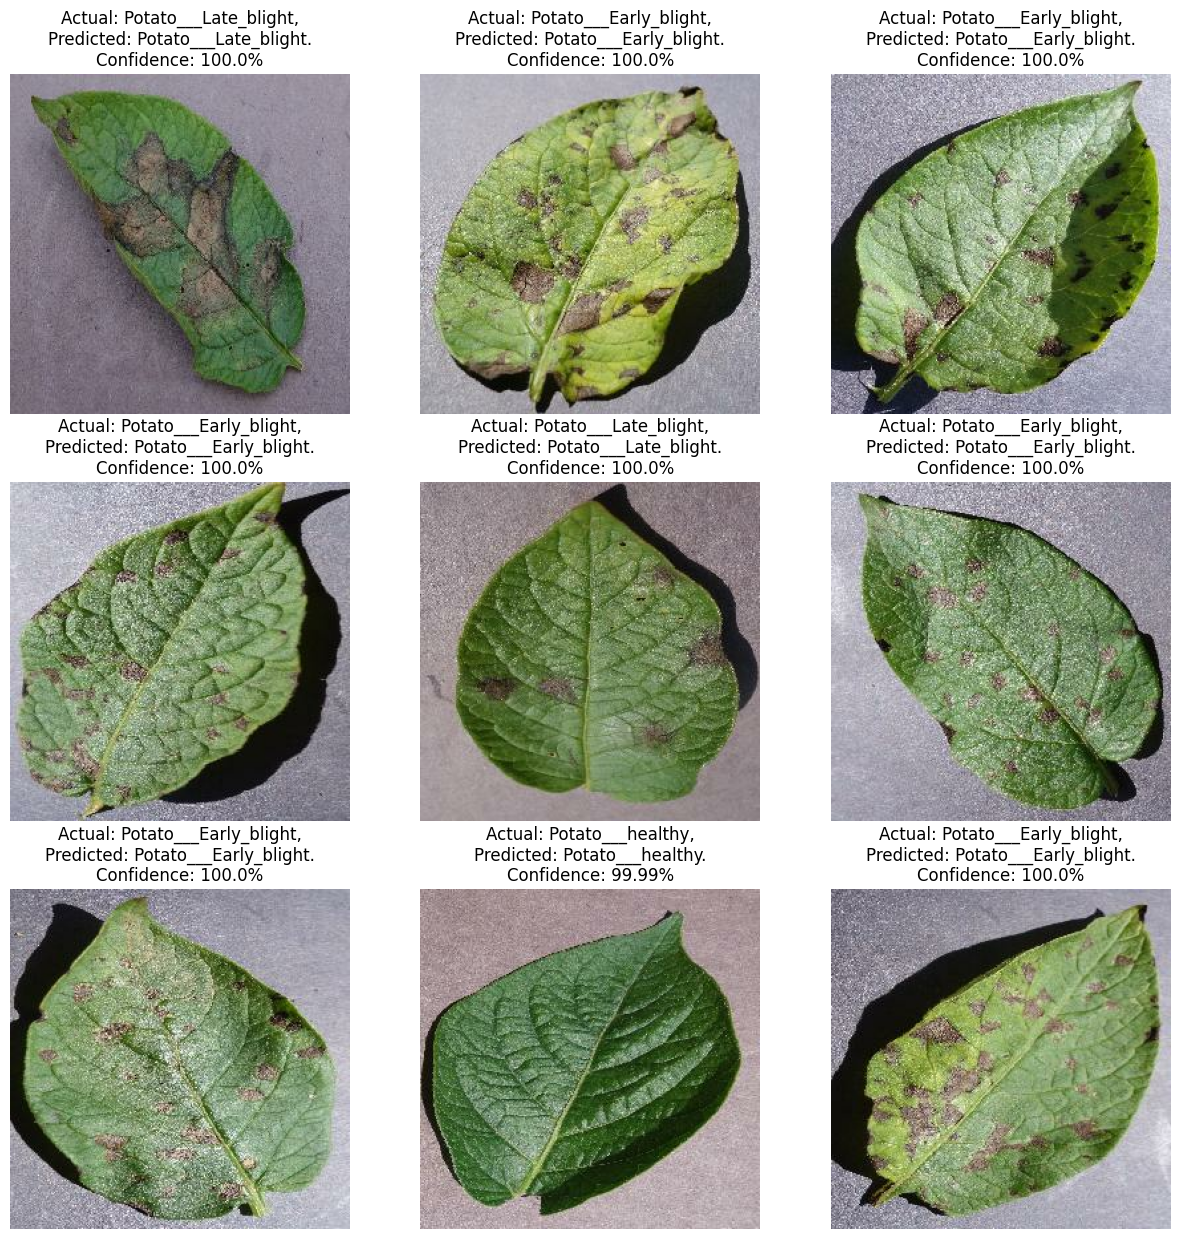

In [79]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 15))  # Set the figure size

# Assume `test_ds` is a TensorFlow dataset with images and labels
for images, labels in test_ds.take(1):  # Take one batch of images and labels from the dataset
    for i in range(9):  # Loop through the first 9 images in the batch
        ax = plt.subplot(3, 3, i + 1)  # Create a subplot for each image
        plt.imshow(images[i].numpy().astype("uint8"))  # Display the image

        # Predict the class and confidence for the current image
        predicted_class, confidence = predict(model, images[i])
        actual_class = class_names[labels[i]]  # Get the actual class name from labels

        # Set the title with actual and predicted class names and confidence score
        plt.title(f"Actual: {actual_class},\nPredicted: {predicted_class}.\nConfidence: {confidence}%")
        
        plt.axis("off")  # Hide the axes

plt.show()  # Display the figure


## saving the model 

In [80]:
import os

model_version = max([int(i) for i in os.listdir("../models") + [0]])+1
model.save(f"../models/{model_version}")

INFO:tensorflow:Assets written to: ../models/1\assets


INFO:tensorflow:Assets written to: ../models/1\assets


In [81]:
model.save("../potatoes.h5")